### Portfolio Selection

#### 1. Markowitz Portfolio Selection

- 1953년 Harry Markowitz가 개발한 현대적 자산 배분 방법이다.
- 위험을 최소화하고, Sharpe Ratio가 극대화되는 지점에서 배분 비율을 결정한다.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '005380', '035420'] : 
    data = pd.concat([data, web.DataReader(code, 'naver', start = '2015-01-01', end = '2024-03-17')['Close'].astype(float)], axis=1)

data.columns = ['samsung', 'hynics', 'hyundai_motor', 'naver']
# 5개의 종목을 선정하는 경우
noa = len(data.columns) # noa : Number of Asset, 종목의 개수
data.index = pd.to_datetime(data.index)

In [2]:
data.head()

,samsung,hynics,hyundai_motor,naver
2015-01-02,26600.0,47750.0,169000.0,146407.0
2015-01-05,26660.0,47650.0,168000.0,150012.0
2015-01-06,25900.0,47500.0,164500.0,148811.0
2015-01-07,26140.0,47400.0,170000.0,146607.0
2015-01-08,26280.0,49950.0,178000.0,149011.0


배분 비율을 추정하는 train data와 전략의 성과를 추정하는 test data를 분리한다

In [3]:
data_test = data['2020':]
data_train = data[:'2019']

**Montecarlo Simulation**

최적 배분 비율 추정을 위해 몬테카를로 시뮬레이션을 수행한다.

In [4]:
weights = np.random.random(noa)
weights /= sum(weights)

# get returns
ret = data_train.pct_change().dropna()
train_days = len(data_train)

# use sample mean and variance as estimates of expected portfolio return and variance
port_mean = np.sum(weights * ret.mean() * train_days) # sample mean
# 곱해주는 수는 data의 row의 길이이다
port_var = np.dot(weights.T, np.dot(ret.cov() * train_days, weights)) #sample variance
port_std = np.sqrt(port_var) # sample standard deviation

초기의 가중치를 랜덤하게 지정해 준 다음, return을 계산하여 전체 포트폴리오의 수익률 평균과 리스크를 계산해 주는 과정을 거친다

In [5]:
port_rets = []
port_std = []
all_weights = []

def ret_std(weight, ret): # estimate portfolio mean, std
    port_mean = np.sum(weight * ret.mean() * 1026)
    port_var = np.dot(weight.T, np.dot(ret.cov() * 1026, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(10000):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    all_weights.append(weight)  # 가중치 저장
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sharpe_ratio = np.array(port_rets) / np.array(port_std)
# sharpe ratio

mean variance 평면에 가능한 포트폴리오의 경우들을 전부 뽑기 위해서 우선 포트폴리오의 mean과 standard deviation(risk)를 계산해 주는 함수를 임의로 지정한다.

5000번의 몬테카를로 시뮬레이션을 돌렸을 때의 결과를 생성하여 평균과 risk에 대한 정보를 리스트에 stack해 준다

In [6]:
# 최대 Sharpe Ratio 찾기
max_sharpe_idx = np.argmax(sharpe_ratio)
max_sharpe_return = port_rets[max_sharpe_idx]
max_sharpe_std = port_std[max_sharpe_idx]

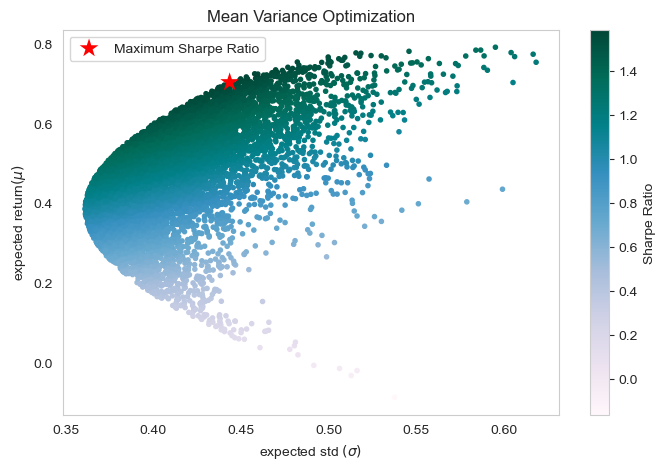

In [7]:
plt.figure(figsize = (8,5))
plt.scatter(port_std, port_rets, c = sharpe_ratio, marker = '.',  cmap='PuBuGn')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(
    max_sharpe_std, max_sharpe_return, 
    c = 'red', s = 200, edgecolors = 'none', label = 'Maximum Sharpe Ratio', marker = '*'
)
plt.legend(labelspacing=0.8)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$')
plt.title('Mean Variance Optimization')
plt.grid()

In [8]:
max_sharpe_idx = np.argmax(sharpe_ratio)
optimal_weights = all_weights[max_sharpe_idx]

train data를 이용해 추정한 최적의 배분 비율을 다음과 같이 구할 수 있다

In [9]:
optimal_weights

array([0.61219587, 0.21411223, 0.00756982, 0.16612208])

max sharpe ratio를 구성하는 index는 다음과 같이 볼 수 있다

In [10]:
print(max_sharpe_idx)

2089


optimal weights를 test data를 이용해 성과를 추정해 볼 수 있다

In [11]:
weighted_portfolio = np.log(data_test / data_test.shift(1)).dropna() * optimal_weights
equal_weighted_portfolio = np.log(data_test / data_test.shift(1)).dropna() * (1 / 5)

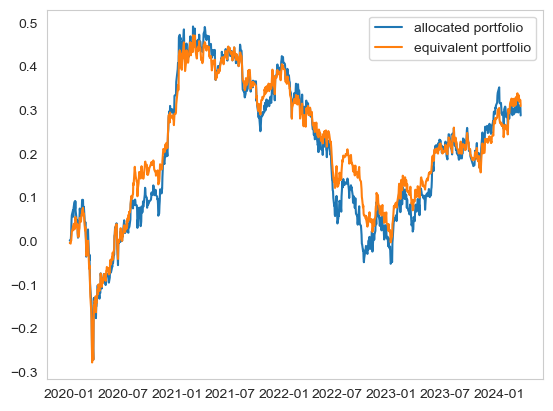

In [12]:
plt.plot(
    weighted_portfolio.sum(axis = 1).cumsum(),
    label = 'allocated portfolio'
)
plt.plot(
    equal_weighted_portfolio.sum(axis = 1).cumsum(),
    label = 'equivalent portfolio'
)
plt.legend()
plt.grid(False)
plt.show()

#### 2. Capital Market Line(CML)

In [13]:
max_sharpe_std

0.4435906543796426

In [14]:
rf = 0.035
slope = (max_sharpe_return - rf) / (max_sharpe_std)
var_list = [x * slope + rf for x in np.linspace(0, 1, 2500)]

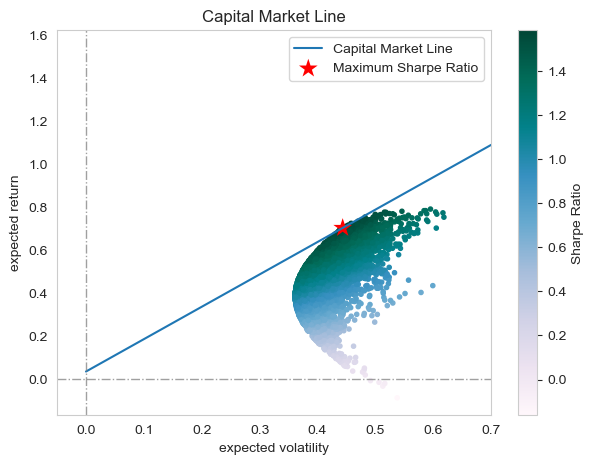

In [15]:
x = np.linspace(0,1,2500)
y = var_list

plt.figure(figsize = (7, 5))
plt.plot(x, y, label = 'Capital Market Line')
plt.scatter(port_std, port_rets, c = sharpe_ratio, marker = '.',  cmap='PuBuGn')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(
    max_sharpe_std, max_sharpe_return, 
    c = 'red', s = 200, edgecolors = 'none', label = 'Maximum Sharpe Ratio', marker = '*'
)

plt.legend()
plt.axhline(0, color = 'gray', ls = '-.', lw = 1, alpha = 0.75)
plt.axvline(0, color = 'gray', ls = '-.', lw = 1, alpha = 0.75)
plt.grid(False)
plt.xlim([-0.05, 0.7])
plt.xlabel('expected volatility')
plt.ylabel('expected return')    
plt.title('Capital Market Line')
plt.show()

#### 3. Capital Asset Pricing Model

In [16]:
kospi = web.DataReader('KOSPI', 'naver', start = '2015-01-01', end = '2024-03-17').astype(float)
kospi.index = pd.to_datetime(kospi.index)

In [17]:
kospi_ret = kospi['Close'].pct_change().dropna()

In [18]:
ret = data.pct_change().dropna()

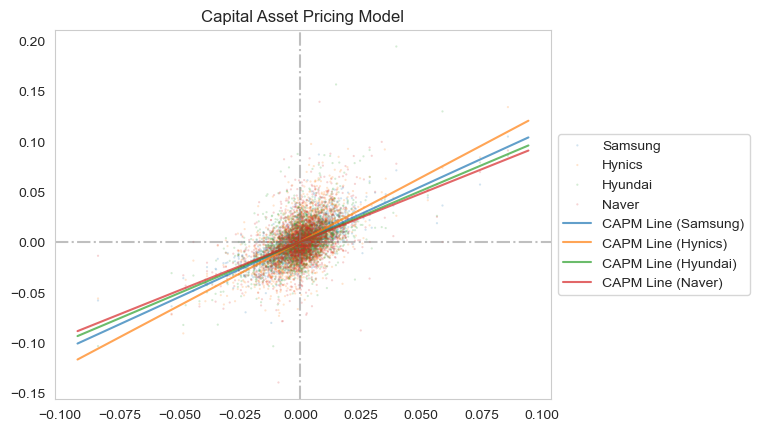

In [19]:
beta0, alpha0 = np.polyfit(x = kospi_ret , y = ret['samsung'] ,deg = 1)
beta1, alpha1 = np.polyfit(x = kospi_ret , y = ret['hynics'] ,deg = 1)
beta2, alpha2 = np.polyfit(x = kospi_ret , y = ret['hyundai_motor'] ,deg = 1)
beta3, alpha3 = np.polyfit(x = kospi_ret , y = ret['naver'] ,deg = 1)

plt.axvline(0, color = 'grey', alpha = 0.5, ls = '-.')
plt.axhline(0, color = 'grey', alpha = 0.5, ls = '-.')

plt.scatter(
    y = ret['samsung'], 
    x = kospi_ret, 
    label = 'Samsung',
    marker = '.',
    s = 10,
    edgecolor = 'none',
    alpha = 0.2
)
plt.scatter(
    y = ret['hynics'], 
    x = kospi_ret, 
    label = 'Hynics',
    marker = '.',
    s = 10,
    edgecolor = 'none',
    alpha = 0.2
)
plt.scatter(
    y = ret['hyundai_motor'], 
    x = kospi_ret, 
    label = 'Hyundai',
    marker = '.',
    s = 10,
    edgecolor = 'none',
    alpha = 0.2
)
plt.scatter(
    y = ret['naver'], 
    x = kospi_ret, 
    label = 'Naver',
    marker = '.',
    s = 10,
    edgecolor = 'none',
    alpha = 0.2
)

x_vals = np.array(plt.xlim())
plt.plot(x_vals, alpha0 + beta0 * x_vals, label = 'CAPM Line (Samsung)', alpha = 0.7)
plt.plot(x_vals, alpha1 + beta1 * x_vals, label = 'CAPM Line (Hynics)', alpha = 0.7)
plt.plot(x_vals, alpha2 + beta2 * x_vals, label = 'CAPM Line (Hyundai)', alpha = 0.7)
plt.plot(x_vals, alpha3 + beta3 * x_vals, label = 'CAPM Line (Naver)', alpha = 0.7)

plt.grid(False)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Capital Asset Pricing Model')
plt.show()